<a href="https://colab.research.google.com/github/jtghchau/TextClassification/blob/main/Probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

modelName1 = "distilbert-base-uncased-finetuned-sst-2-english"
model1 = AutoModelForSequenceClassification.from_pretrained(modelName1, output_hidden_states=True)
tokenizer1 = AutoTokenizer.from_pretrained(modelName1)
model1.eval()

modelName2 = "textattack/bert-base-uncased-SST-2"
model2 = AutoModelForSequenceClassification.from_pretrained(modelName2, output_hidden_states=True)
tokenizer2 = AutoTokenizer.from_pretrained(modelName2)
model2.eval()

dataset = load_dataset("imdb")
samples = dataset["test"].shuffle(seed=42).select(range(300))

In [ ]:
def extractHiddenStates(text, model, tokenizer):
  inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
  with torch.no_grad():
      outputs = model(**inputs)
  return outputs.hidden_states

hiddenStatesPerLayer1 = [[] for _ in range(model1.config.num_hidden_layers + 1)]
labels1 = []

hiddenStatesPerLayer2 = [[] for _ in range(model2.config.num_hidden_layers + 1)]
labels2 = []

for example in samples:
    text, label = example["text"], example["label"]
    hiddenStates = extractHiddenStates(text, model1, tokenizer1)
    clsEmbeddings = [layer[0, 0, :].numpy() for layer in hiddenStates]

    for i, emb in enumerate(clsEmbeddings):
        hiddenStatesPerLayer1[i].append(emb)

    labels1.append(label)

for example in samples:
    text, label = example["text"], example["label"]
    hiddenStates = extractHiddenStates(text, model2, tokenizer2)
    clsEmbeddings = [layer[0, 0, :].numpy() for layer in hiddenStates]

    for i, emb in enumerate(clsEmbeddings):
        hiddenStatesPerLayer2[i].append(emb)

    labels2.append(label)

labels1 = torch.tensor(labels1, dtype=torch.float32)
layerAccuracies1 = {}

labels2 = torch.tensor(labels2, dtype=torch.float32)
layerAccuracies2 = {}

Layer 0: Accuracy = 0.5000
Layer 1: Accuracy = 0.7300
Layer 2: Accuracy = 0.7700
Layer 3: Accuracy = 0.8233
Layer 4: Accuracy = 0.8433
Layer 5: Accuracy = 0.9900
Layer 6: Accuracy = 0.9667


Layer 0: Accuracy = 0.5000
Layer 1: Accuracy = 0.7000
Layer 2: Accuracy = 0.7633
Layer 3: Accuracy = 0.7633
Layer 4: Accuracy = 0.7967
Layer 5: Accuracy = 0.8000
Layer 6: Accuracy = 0.8267
Layer 7: Accuracy = 0.8533
Layer 8: Accuracy = 0.8567
Layer 9: Accuracy = 0.9100
Layer 10: Accuracy = 0.9800
Layer 11: Accuracy = 0.9900
Layer 12: Accuracy = 0.9867




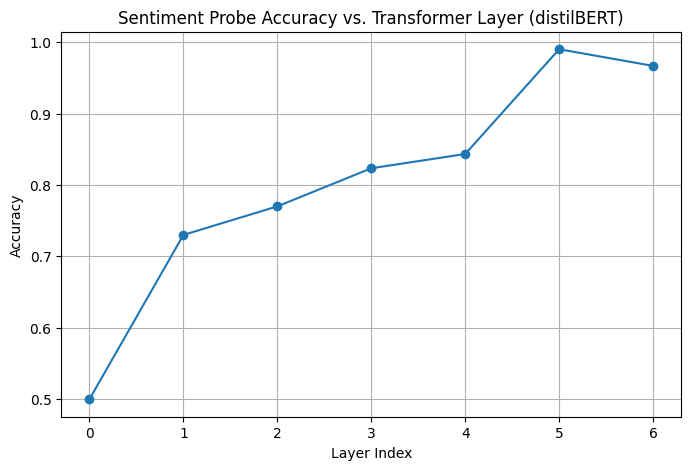

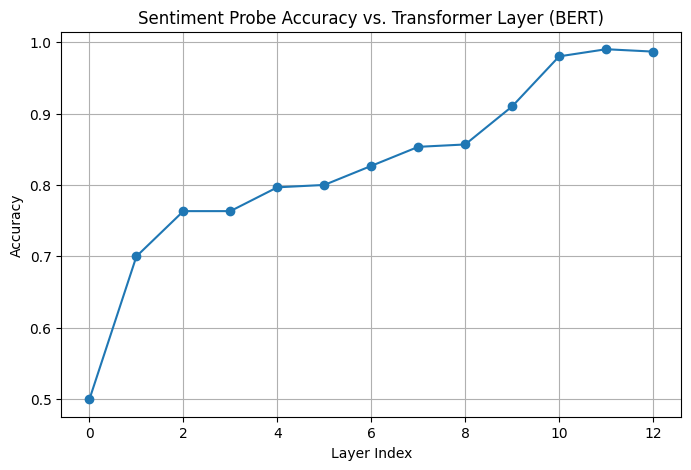

In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x).squeeze(-1)

for layerIdx, embeddings in enumerate(hiddenStatesPerLayer1):
    X = torch.tensor(np.array(embeddings), dtype=torch.float32)
    y = labels1

    modelProbe = LogisticRegression(X.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(modelProbe.parameters(), lr=0.01)

    for epoch in range(100):
        optimizer.zero_grad()
        outputs = modelProbe(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        preds = (torch.sigmoid(modelProbe(X)) > 0.5).float()
        accuracy = (preds == y).float().mean().item()
        layerAccuracies1[layerIdx] = accuracy

for layer, acc in sorted(layerAccuracies1.items()):
    print(f"Layer {layer}: Accuracy = {acc:.4f}")

print("\n")

for layerIdx, embeddings in enumerate(hiddenStatesPerLayer2):
    X = torch.tensor(np.array(embeddings), dtype=torch.float32)
    y = labels2

    modelProbe = LogisticRegression(X.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(modelProbe.parameters(), lr=0.01)

    for epoch in range(100):
        optimizer.zero_grad()
        outputs = modelProbe(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        preds = (torch.sigmoid(modelProbe(X)) > 0.5).float()
        accuracy = (preds == y).float().mean().item()
        layerAccuracies2[layerIdx] = accuracy

for layer, acc in sorted(layerAccuracies2.items()):
    print(f"Layer {layer}: Accuracy = {acc:.4f}")

print("\n")


import matplotlib.pyplot as plt

layers1 = list(layerAccuracies1.keys())
accuracies1 = list(layerAccuracies1.values())

plt.figure(figsize=(8, 5))
plt.plot(layers1, accuracies1, marker='o', linestyle='-')
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.title("Sentiment Probe Accuracy vs. Transformer Layer (distilBERT)")
plt.grid(True)
plt.show()

print("\n")

layers2 = list(layerAccuracies2.keys())
accuracies2 = list(layerAccuracies2.values())

plt.figure(figsize=(8, 5))
plt.plot(layers2, accuracies2, marker='o', linestyle='-')
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.title("Sentiment Probe Accuracy vs. Transformer Layer (BERT)")
plt.grid(True)
plt.show()



---
#**Discussion**:


If I saw strong attention to sentiment words in the 8th layer, I do see a higher accuracy for that layer's embeddings but it is still possible for a higher accuracy to be acheived later on in the later transformer layers.

Surprises:

I was suprised on how the accuracy scaled. I rememeber from our meeting on monday there should be a base line accuracy in which the model should output and if not there is something wrong with its implementation. So I thought it would be a lower accuracy and slowly scale up to a higher accuracy. Based on my data, the starting/minimun accuracy for both models were 50% and jumped up right to around 70% which was a huge jump in my opinion. The peak layer ended up being the second to last layer in both models with the accuracies being 0.99 in both models. But the in the last layer of each model distilBERT has a higher percentage in change compared to BERT. DistilBERT went from 0.9900 to 0.9667 while BERT went from 0.9900 to 0.9867


---



